# 6. Transfer Learning in TensorFlow - Fine Tuning

In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import tensorflow as tf

tf.__version__

'2.9.1'

In [2]:
# Check if we're using a GPU
!nvidia-smi

Tue Jul  5 09:09:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   56C    P8     6W /  N/A |     81MiB /  6144MiB |     25%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Import helper functions we're going to use in this notebook
from extras.helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Lets get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem

In [4]:
# Get 10% of train data of 10 classes of Food101
!curl "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip" --output "Data/Classification/10_food_classes_10_percent.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  160M    0  1495    0     0   1181      0 39:38:34  0:00:01 39:38:33  1182
  0  160M    0  146k    0     0  93275      0  0:30:06  0:00:01  0:30:05 93295
  0  160M    0 1582k    0     0   613k      0  0:04:28  0:00:02  0:04:26  613k
  3  160M    3 5262k    0     0  1471k      0  0:01:51  0:00:03  0:01:48 1472k
  5  160M    5 8238k    0     0  1800k      0  0:01:31  0:00:04  0:01:27 1800k
  6  160M    6 11.1M    0     0  2046k      0  0:01:20  0:00:05  0:01:15 2646k
  9  160M    9 14.7M    0     0  2291k      0  0:01:11  0:00:06  0:01:05 3001k
 10  160M   10 17.3M    0     0  2348k      0  0:01:10  0:00:07  0:01:03 3244k
 12  160M   12 19.7M    0     0  2361k      0  0:01:09  0:00:08  0:01:01 2998k
 14  160M   14 23.8M    0     0  2548k      0  0:01

In [5]:
zip_file = zipfile.ZipFile("Data/Classification/10_food_classes_10_percent.zip")
zip_file.extractall("Data/Classification")
zip_file.close()

In [6]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("Data/Classification/10_food_classes_10_percent")

There are 2 directories and 0 images in 'Data/Classification/10_food_classes_10_percent'.
There are 10 directories and 0 images in 'Data/Classification/10_food_classes_10_percent\test'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in 'Data/Classif

In [7]:
# Create training and test directory paths
train_dir = "Data/Classification/10_food_classes_10_percent/train"
test_dir = "Data/Classification/10_food_classes_10_percent/test"

This time instead of using `ImageDataGenerator` we'll use `tf.keras.preprocessing.image_dataset_from_directory`. This is because it creates a `tf.data.Dataset` object which is much faster to process.

In [8]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [12]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [13]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [15]:
for images, labels in train_data.take(1):
    print(images.shape)
    print(labels.shape)

(32, 224, 224, 3)
(32, 10)


## Modelling experiments we're running
|Experiment|Data|Preprocessing|Model|
|----------|----|-------------|-----|
|Model 0 (baseline)|10 classes of Food101 data (random 10% training data only)|None|Feature Extractor: EfficientNetB0 (pretrained on ImageNet, all layers frozen) with no top|
|Model 1|10 classes of Food101 data (random 1% training data only)|Random Flip, Rotation, Zoom, Height, Width data augmentation|Same as Model 0|
|Model 2|Same as Model 0|Same as Model 1|Same as model 0|
|Model 3|Same as Model 0|Same as Model 1|Fine-tuning: Model 2 (EfficientNetB0 pre-trained on ImageNet) with top layer trained on custom data, top 10 layers unfrozen|
|Model 4|10 classes of Food101 data (100% training data)|Same as Model 1|Same as Model 3|

## Keras Sequential vs Functional API

Sequential API
sequential_model = tf.keras.Sequential(<br>
    [<br>
        tf.keras.layers.Flatten(),<br>
        tf.keras.layers.Dense(64, activation = "relu")<br>
        tf.keras.layers.Dense(64, activation = "relu")<br>
        tf.keras.layers.Dense(10, activation = "softmax")<br>
    ], name = "sequential_model"<br>
)<br>

Functional API<br>
inputs = tf.keras.layers.Input(shape = (28,28))<br>
x = tf.keras.layers.Flatten()(inputs)<br>
x = tf.keras.layers.Dense(64, activation = "relu")(x)<br>
x = tf.keras.layers.Dense(64, activation = "relu")(x)<br>
outputs = tf.keras.layers.Dense(10, activation = "softmax")(x)<br>
functional_model = tf.keras.Model(inputs, outputs, name = "functional_model")<br>


Similarities: compiling, fitting, evaluating
Differences: model construction (the Functional API is more flexible and able to produce more sophisticated models)

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order

But the functional API gives us more flexibility with our models.

In [16]:
# 1. Create the base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top = False,
)

# 2. Freeze the base model (so that the underlying pre-trained patterns aren't updated)
base_model.trainable = False

# 3. Create the inputs into our model
inputs = tf.keras.layers.Input(shape = (224,224,3), name = "input_layer")

# 4. If using Resnet50v2 you will need to normalize inputs; dont need to for efficient-net
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs) 

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through the base model: {x.shape}")

# 6. Average Pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after passing inputs through the global average pooling layer model: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

model_0 = tf.keras.Model(inputs, outputs, name = "model_0")
model_0.summary()

16705208/16705208 [==============================] - 7s 0us/step
Shape after passing inputs through the base model: (None, 7, 7, 1280)
Shape after passing inputs through the global average pooling layer model: (None, 1280)
Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable 

In [18]:
# Compile the model
model_0.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_0 = model_0.fit(
    train_data,
    epochs = 5,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [create_tensorboard_callback("TensorBoard/Classification", "efficientnetb0_feature_extractor")]
)

Saving TensorBoard log files to: TensorBoard/Classification/efficientnetb0_feature_extractor/20220705-103100
Epoch 1/5
24/24 [==============================] - 94s 3s/step - loss: 1.9086 - accuracy: 0.3893 - val_loss: 1.3338 - val_accuracy: 0.7092
Epoch 2/5
24/24 [==============================] - 59s 3s/step - loss: 1.1169 - accuracy: 0.7560 - val_loss: 0.8810 - val_accuracy: 0.8128
Epoch 3/5
24/24 [==============================] - 58s 2s/step - loss: 0.8100 - accuracy: 0.8360 - val_loss: 0.7039 - val_accuracy: 0.8380
Epoch 4/5
24/24 [==============================] - 57s 2s/step - loss: 0.6513 - accuracy: 0.8613 - val_loss: 0.6169 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 58s 2s/step - loss: 0.5509 - accuracy: 0.8813 - val_loss: 0.5598 - val_accuracy: 0.8680


In [19]:
model_0.evaluate(test_data)

79/79 [==============================] - 44s 558ms/step - loss: 0.5598 - accuracy: 0.8680


[0.5597534775733948, 0.8679999709129333]

In [20]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [21]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

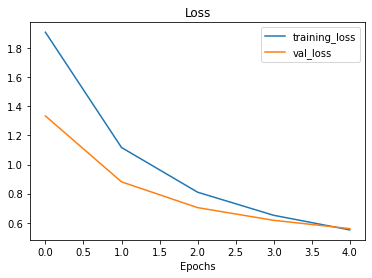

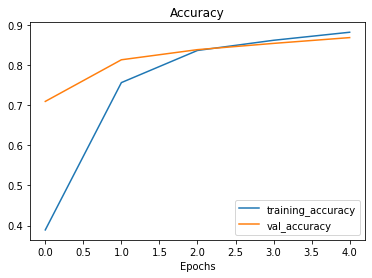

In [22]:
plot_loss_curves(history_0)